In [1]:
# import autograd-wrapped numpy
import autograd.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# datapath to data
datapath = './superlearn_datasets/'

-----
some handy tools

In [2]:
from autograd import grad
from autograd import hessian
def newtons_method(g, max_its, w):
    gradient = grad(g)
    hess = hessian(g)
    epsilon = 1e-7
    
    weight_his = [w]
    cost_his = [g(w)]
    for k in range(max_its):
        grad_eval = gradient(w)
        hess_eval = hess(w)
        
        hess_eval.shape = (int(np.size(hess_eval)**0.5),
                           int(np.size(hess_eval)**0.5))
        A = hess_eval + epsilon*np.eye(w.size)
        b = grad_eval
        w = np.linalg.solve(A, np.dot(A,w)-b)
        weight_his.append(w)
        cost_his.append(g(w))
    return weight_his, cost_his

def gradient_descent(g, max_its, w):
    gradient = grad(g)
    weight_his = [w]
    cost_his = [g(w)]
    for k in range(max_its):
        grad_eval = gradient(w)
        w = w - grad_eval
        weight_his.append(w)
        cost_his.append(g(w))
    return weight_his, cost_his

-----

# 7.2

In [3]:
# load in dataset
csvname = datapath + '4class_data.csv'
data = np.loadtxt(csvname,delimiter = ',');
x = data[:-1,:]
y = data[-1:,:] 

l = 1e-3

def model(x, w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

def fusion_rule(w):
    return np.argmax(model(x, w), axis = 0)

def softmax(w):
    cost = np.sum(np.log(1+np.exp(-y*model(x, w))))
    return cost/float(np.size(y))

w = 0.1*np.random.randn(3,4)

for j in range(4):
    _y = y
    y = np.apply_along_axis(lambda x : 1.0 if x == j else -1.0, 0, y)
    weight_his, _ = newtons_method(softmax, 1000, w[:, j])
    w[:, j] = weight_his[-1]
    y = _y

print(y, fusion_rule(w), sep = '\n')
print(f"There are {np.sum(y.squeeze() != fusion_rule(w))} mismatches in total")

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
[0 0 0 0 0 0 1 2 0 0 0 1 2 1 1 1 1 1 3 1 0 1 2 2 2 2 2 2 2 3 2 1 3 3 3 3 3
 3 3 3]
There are 10 mismatches in total


# 7.3

In [4]:
# load in dataset
data = np.loadtxt(datapath + '3class_data.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]

lam = 10 ** -5
w = 0.1*np.random.randn(3,3)

def model(x, w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

def multiclass_perceptron(w):
    all_evals = model(x, w)
    a = np.max(all_evals, axis = 0)
    b = all_evals[y.astype(int).flatten(), np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    cost = cost + lam * np.linalg.norm(w[1:, :], 'fro')**2
    
    return cost/float(np.size(y))

weight_his, _ = gradient_descent(multiclass_perceptron, 1000, w)
w = weight_his[-1]
print(y, np.argmax(model(x, w), axis=0), sep='\n')
print(f"There are {np.sum(y.squeeze() != np.argmax(model(x, w), axis=0))} mismatches in total")

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2.]]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
There are 0 mismatches in total


# 7.4

\begin{align}
  g(w_0, w_1) &=  \frac{1}{P}\sum_{p=1}^{P}\max(0, \mathring{\boldsymbol{x_p}}^T(\boldsymbol{w}_0-\boldsymbol{w}_{1}), \mathring{\boldsymbol{x_p}}^T(\boldsymbol{w}_1-\boldsymbol{w}_{0}))\\
              &= \frac{1}{P}\sum_{p=1}^P (0, \mathring{\boldsymbol{x_p}}^T |\boldsymbol{w_1}-\boldsymbol{w_0}|)
\end{align}
Because in this case, $y_1 = 1, y_0 = 0$, so the model output is either 0 or a positive answer. So if we replace the $|\boldsymbol{w_1}-\boldsymbol{w_0}|$ with $-\boldsymbol{w}$, then it's changed into

$$
\frac{1}{P}\sum_{p=1}^P (0, -y_p\mathring{\boldsymbol{x_p}}^Tw)
$$
where $y_p=0 \text{ or } 1$

# 7.8

because ReLU and Softmax function are convex, as we have proved before. A simple sum up will not change the convexity of the cost function. So they are convex

# 9.2

In [5]:
from sklearn.datasets import fetch_openml
from skimage.feature import hog
from skimage import data, exposure
# import MNIST
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# re-shape input/output data
x = np.array(x.T)
y = np.array([int(v) for v in y])[np.newaxis,:]

for i in range(x.shape[1]):
    x[:,i] = x[:,i] / np.linalg.norm(x[:,i])

print(x.shape)
print(y.shape)

/Users/junran/.anconda3/anaconda3/envs/machine-learning/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(784, 70000)
(1, 70000)


prepare for the data:

In [6]:
import random

def get_train_set(x, y):
    return x[:, 0:50000], y[:, 0:50000]

def get_test_set(x, y):
    return x[:, 50000:], y[:, 50000:]


feature design:

In [7]:
def convert_edges(x):
#     x = x.T
#     features = []
#     for i, image in enumerate(x):
#         image = image.reshape((28, 28))
#         _, image = hog(
#             image,
#             orientations=9,
#             pixels_per_cell=(3, 3),
#             cells_per_block=(1, 1),
#             visualize=True,
#         )
#         image = exposure.rescale_intensity(image, in_range=(0, 10))
#         features.append(image)
#     features = np.array(features)
#     features = features.reshape((features.shape[0], -1))
#     return features.T
    horz_kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    vert_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

    # histogram bins
    bins = np.array([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5])

    # initialize the new training dataset
    trainingx_hist = np.zeros([81*len(bins),x.shape[1]])

    for pic_id in range(x.shape[1]):

        # reshape the data into the shape of the picture
        picture = x[0:, pic_id].reshape(28,28)

        # feature data for the 81 blocks in a photo
        picture_hist = np.zeros([81,len(bins)])

        for i in range(9):
            # y coords for a block
            ys = 3*i
            ye = 3*(i+1)
            for j in range(9):
                # x coords for a block
                xs= 3*j
                xe= 3*(j+1)     

                # extract the block
                block = picture[xs:xe, ys:ye]

                # Convolve the block
                xcomp = np.sum(np.multiply(block, horz_kernel))
                ycomp = np.sum(np.multiply(block, vert_kernel))

                # clac the block index
                block_num = i*9 + j

                # skip over all blocks that have no edges or calculate the angle of the vector
                if(xcomp == 0 and ycomp == 0):
                    pass
                else:
                    # find the angle of the vector
                    ang = np.arctan2(ycomp,xcomp)

                    # make all angles positive
                    if ang < 0:
                        ang += np.pi

                    # convert to degrees
                    ang = (ang * 360) / (2*np.pi)

                    # find the closest angle and get the index of it in the histogram
                    picture_hist[block_num, np.argmin(np.abs(bins - ang))] = 1


        trainingx_hist[:, pic_id] = np.copy(picture_hist.flatten())
    print(trainingx_hist.shape)
    return trainingx_hist


#print(x.shape)
#print(convert_edges(get_features(train_set)).shape)
features, targets = get_train_set(x, y)
print(features.shape, targets.shape)
features = convert_edges(features)
print(features.shape, targets.shape)
# histogram = x
# targets = y

(784, 50000) (1, 50000)
(648, 50000)
(648, 50000) (1, 50000)


In [8]:
w = 0.1*np.random.rand(649, 10)
print(targets)
print(f"{np.sum(targets.squeeze() != np.argmax(model(features, w), axis=0))} miss")

def train_with_feature():
    batch_size = 200
    epoch = 20
    def train_mini_batch(batch_size, epoch, w):
        weight = []
        cost = []
        from tqdm import tqdm
        for i in range(epoch):
            assert(targets.shape[1] == features.shape[1])
            print(f"running epoch {i}")
            feature_list = np.split(features, features.shape[1]/batch_size, axis=1)
            target_list = np.split(targets, targets.shape[1]/batch_size, axis=1)
            for x, y in tqdm(zip(feature_list, target_list)):
                def multiclass_softmax(w):  
                    all_evals = model(x, w)
                    #print(x.shape, y.shape, w.shape)
                    b = all_evals[y.astype(int).flatten(), np.arange(np.size(y))]  
                    a = (all_evals - b)
                    a = np.exp(a)   
                    cost = a.sum(axis=0)
                    cost = np.log(1 + cost)
                    return np.sum(cost) / float(np.size(y))
                weight_his, cost_his = gradient_descent(multiclass_softmax, 1, w)
                w = weight_his[-1]
            weight.append(w)
            cost.append(cost_his[-1])
            print(f"cost is {cost[-1]}")
            print(f"{np.sum(targets.squeeze() != np.argmax(model(features, w), axis=0))} miss")
        return weight, cost
    return train_mini_batch(batch_size, epoch, w)

weight, cost = train_with_feature()

[[5 0 4 ... 8 4 8]]
45070 miss
running epoch 0


250it [00:00, 552.84it/s]


cost is 0.8861515781298581
3583 miss
running epoch 1


250it [00:00, 345.55it/s]


cost is 0.8433973792790325
3082 miss
running epoch 2


250it [00:01, 247.35it/s]


cost is 0.8250145512926464
2832 miss
running epoch 3


250it [00:00, 280.48it/s]


cost is 0.8142890229678591
2688 miss
running epoch 4


250it [00:00, 471.56it/s]


cost is 0.8070861149234435
2582 miss
running epoch 5


250it [00:00, 404.17it/s]


cost is 0.801821814055128
2511 miss
running epoch 6


250it [00:00, 471.91it/s]


cost is 0.7977472272917271
2445 miss
running epoch 7


250it [00:00, 355.94it/s]


cost is 0.7944604277550897
2394 miss
running epoch 8


250it [00:01, 245.77it/s]


cost is 0.7917260625932104
2343 miss
running epoch 9


250it [00:00, 343.89it/s]


cost is 0.7893970017063668
2301 miss
running epoch 10


250it [00:00, 422.70it/s]


cost is 0.7873763489407745
2255 miss
running epoch 11


250it [00:00, 444.41it/s]


cost is 0.7855974826672576
2235 miss
running epoch 12


250it [00:00, 290.36it/s]


cost is 0.7840128977991496
2222 miss
running epoch 13


250it [00:00, 316.42it/s]


cost is 0.7825876471707247
2199 miss
running epoch 14


250it [00:00, 337.21it/s]


cost is 0.7812953208963828
2169 miss
running epoch 15


250it [00:00, 304.01it/s]


cost is 0.7801154908042759
2149 miss
running epoch 16


250it [00:00, 281.55it/s]


cost is 0.7790320336682144
2141 miss
running epoch 17


250it [00:01, 235.61it/s]


cost is 0.7780319994301549
2118 miss
running epoch 18


250it [00:00, 359.54it/s]


cost is 0.7771048274985641
2101 miss
running epoch 19


250it [00:01, 208.51it/s]

cost is 0.7762417913038456
2091 miss


In [9]:
#print(weight)
features, targets = get_test_set(x, y)
features = convert_edges(features)
def test_with_feature(w):
#     print(f"There are {np.sum(y.squeeze() != np.argmax(model(x, weight[-1]), axis=0))} mismatch in total")
    return np.sum(targets.squeeze() != np.argmax(model(features, w), axis=0))
#print(weight[-1].shape)
mismatches = []
for w in weight:
    mismatch = test_with_feature(w)
    mismatches.append(mismatch)

(648, 20000)


plot the cost and mismatch

In [10]:
print(test_with_feature(w))

936


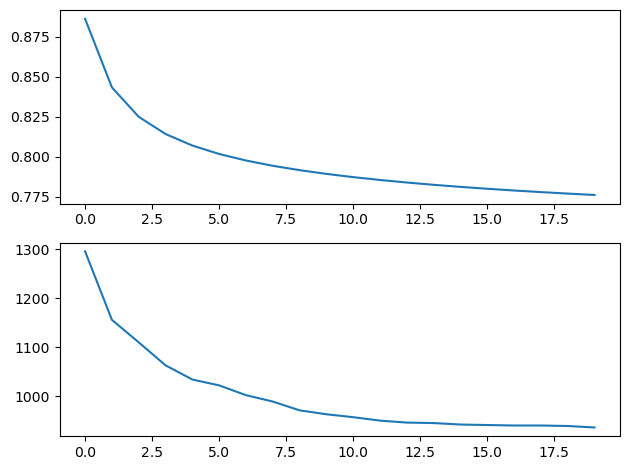

In [11]:
plt.subplot(211)
plt.plot(cost)
plt.subplot(212)
plt.plot(mismatches)

In [12]:
features, targets = get_train_set(x, y)
w = 0.1*np.random.rand(785, 10)

def train_without_feature():
    batch_size = 200
    epoch = 20
    
    def train_mini_batch(batch_size, epoch, w):
        weight = []
        cost = []
        from tqdm import tqdm
        for i in range(epoch):
            assert(targets.shape[1] == features.shape[1])
            print(f"running epoch {i}")
            feature_list = np.split(features, features.shape[1]/batch_size, axis=1)
            target_list = np.split(targets, targets.shape[1]/batch_size, axis=1)
            for x, y in tqdm(zip(feature_list, target_list)):
                def multiclass_softmax(w):  
                    all_evals = model(x, w)
                    #print(x.shape, y.shape, w.shape)
                    b = all_evals[y.astype(int).flatten(), np.arange(np.size(y))]  
                    a = (all_evals - b)
                    a = np.exp(a)   
                    cost = a.sum(axis=0)
                    cost = np.log(1 + cost)
                    return np.sum(cost) / float(np.size(y))
                weight_his, cost_his = gradient_descent(multiclass_softmax, 1, w)
                w = weight_his[-1]
            weight.append(w)
            cost.append(cost_his[-1])
            print(f"cost is {cost[-1]}")
            print(f"{np.sum(targets.squeeze() != np.argmax(model(features, w), axis=0))} miss")
        return weight, cost
    return train_mini_batch(batch_size, epoch, w)

weight_, cost_ = train_without_feature()

running epoch 0


250it [00:01, 248.70it/s]


cost is 1.457438180170643
8619 miss
running epoch 1


250it [00:00, 283.74it/s]


cost is 1.2758051013420062
7589 miss
running epoch 2


250it [00:00, 282.71it/s]


cost is 1.199745793573011
7029 miss
running epoch 3


250it [00:01, 231.92it/s]


cost is 1.1573440804223711
6653 miss
running epoch 4


250it [00:01, 248.05it/s]


cost is 1.129980383405246
6398 miss
running epoch 5


250it [00:01, 222.84it/s]


cost is 1.1106313281729254
6187 miss
running epoch 6


250it [00:00, 296.21it/s]


cost is 1.0960531832934397
6054 miss
running epoch 7


250it [00:00, 322.19it/s]


cost is 1.0845445029186878
5938 miss
running epoch 8


250it [00:01, 229.14it/s]


cost is 1.0751299276110504
5828 miss
running epoch 9


250it [00:00, 330.33it/s]


cost is 1.0672118729039746
5704 miss
running epoch 10


250it [00:00, 523.89it/s]


cost is 1.0604045460342524
5604 miss
running epoch 11


250it [00:00, 505.10it/s]


cost is 1.054448040199317
5527 miss
running epoch 12


250it [00:00, 324.17it/s]


cost is 1.049160904773955
5478 miss
running epoch 13


250it [00:00, 397.13it/s]


cost is 1.0444125521282475
5420 miss
running epoch 14


250it [00:00, 374.86it/s]


cost is 1.0401064920039083
5373 miss
running epoch 15


250it [00:00, 393.03it/s]


cost is 1.0361697628267956
5318 miss
running epoch 16


250it [00:00, 470.67it/s]


cost is 1.0325460549600738
5282 miss
running epoch 17


250it [00:00, 501.39it/s]


cost is 1.0291911107753924
5233 miss
running epoch 18


250it [00:01, 236.67it/s]


cost is 1.0260695717321269
5182 miss
running epoch 19


250it [00:00, 314.09it/s]


cost is 1.0231527697959617
5143 miss


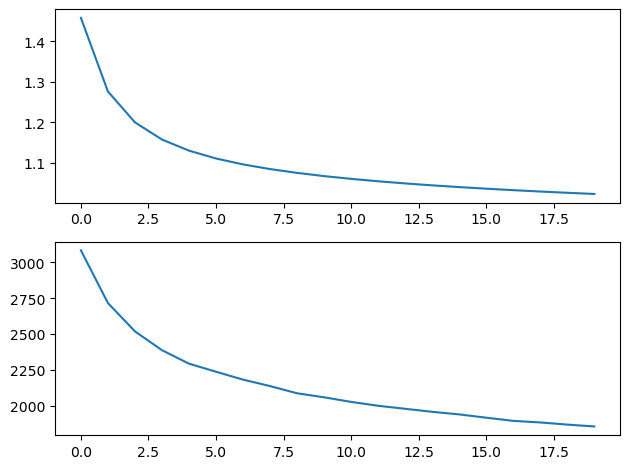

In [13]:
w = 0.1*np.random.rand(785, 10)
features, targets = get_test_set(x, y)
def test_without_feature(w):
    #print(f"There are {np.sum(y.squeeze() != np.argmax(model(x, w), axis=0))} mismatch in total")
    return np.sum(targets.squeeze() != np.argmax(model(features, w), axis=0))
#print(weight[-1].shape)
mismatches = []
for w in weight_:
    mismatch = test_without_feature(w)
    mismatches.append(mismatch)
plt.subplot(211)
plt.plot(cost_)
plt.subplot(212)
plt.plot(mismatches)